In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow import keras
from keras import layers

2023-06-30 15:16:20.611817: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-30 15:16:20.653400: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-30 15:16:20.654017: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-30 15:16:21.483827: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [62]:
train_data_all = pd.read_csv("../data/train.csv")
test_data_all = pd.read_csv("../data/test.csv")

In [80]:
# replace missing values in training data

def filter_df(df):

    df_filtered = pd.DataFrame()

    for column in df.columns:
        dtype = df[column].dtype

        # use -1 for numerical data, "NA" for strings (objects)
        if dtype == "int64" or dtype == "float64":
            val = -1
        else:
            val = "NA"
        df[column] = df[column].fillna(val)

    # ignore name, and ticket (for now)
    df_filtered = df.drop(columns=["Name", "Ticket"])

    # convert age to float for treatment as continuous variable
    df_filtered["Age"] = df_filtered["Age"].astype('float64')

    return df_filtered

In [81]:
train_data_filtered = filter_df(train_data_all).drop(columns="PassengerId")
test_data_filtered = filter_df(test_data_all)

In [82]:
# split into training and validation datasets

val_frac = .2
val_df = train_data_filtered.sample(frac=0.2)
train_df = train_data_filtered.drop(val_df.index)

In [83]:
# convert pd DataFrame to tf Dataset labelled with answers
def dataframe_to_dataset(df):
    
    df = df.copy()
    labels = df.pop("Survived")
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    ds = ds.shuffle(buffer_size=len(df))

    return ds

In [84]:
# convert to Datasets
train_ds = dataframe_to_dataset(train_df)
val_ds = dataframe_to_dataset(val_df)

# batch Datasets
batch_size = 32
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

In [85]:
from tensorflow.keras.layers import StringLookup

def encode_string_feature(feature, name, feature_ds):

    lookup = StringLookup(output_mode="one_hot")
    lookup.adapt(feature_ds)

    return lookup(feature)

In [86]:
from tensorflow.keras.layers import IntegerLookup

def encode_integer_feature(feature, name, feature_ds):

    lookup = IntegerLookup(output_mode="one_hot")
    lookup.adapt(feature_ds)

    return lookup(feature)

In [87]:
from tensorflow.keras.layers import Normalization

def encode_float_feature(feature, name, feature_ds):

    normalizer = Normalization()
    normalizer.adapt(feature_ds)
    
    return normalizer(feature)

In [88]:
def encode_feature(feature, name, dataset):

    # construct dataset with only given feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # build encoder based on feature dtype
    dtype = feature_ds.element_spec.dtype

    if dtype == tf.string:
        encoded_feature = encode_string_feature(feature, name, feature_ds)
    elif dtype == tf.int64:
        encoded_feature = encode_integer_feature(feature, name, feature_ds)
    elif dtype == tf.float64:
        encoded_feature = encode_float_feature(feature, name, feature_ds)
    else:
        print("Unexpected datatype: " + str(dtype))
        encoded_feature = "AAAAaaaAA"

    return encoded_feature


In [89]:
train_ds.element_spec[0]

{'Pclass': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'Sex': TensorSpec(shape=(None,), dtype=tf.string, name=None),
 'Age': TensorSpec(shape=(None,), dtype=tf.float64, name=None),
 'SibSp': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'Parch': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'Fare': TensorSpec(shape=(None,), dtype=tf.float64, name=None),
 'Cabin': TensorSpec(shape=(None,), dtype=tf.string, name=None),
 'Embarked': TensorSpec(shape=(None,), dtype=tf.string, name=None)}

In [90]:
# build input layers based on feature specs from ds

all_inputs = dict()

features = train_ds.element_spec[0]

for name, spec in features.items():
    all_inputs[name] = keras.Input(
        shape=(1,),
        name=name,
        dtype=spec.dtype
    )

In [91]:
# build individual encoding layers for each feature

encodings = dict()

for name, spec in features.items():
    encodings[name] = encode_feature(
        all_inputs[name],
        name,
        train_ds
    )

# concatenate feature encodings

all_features = layers.concatenate(encodings.values())

2023-06-30 15:57:33.653520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype string and shape [713]
	 [[{{node Placeholder/_6}}]]
2023-06-30 15:57:33.654467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype string and shape [713]
	 [[{{node Placeholder/_2}}]]
2023-06-30 15:57:33.756206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_3' with dtype double and shape [713]
	

In [92]:
# build dense network from encoded features to predicted survival

x = layers.Dense(32, activation="relu")(all_features)
x = layers.Dropout(0.5)(x)

inputs = list(all_inputs.values())
output = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(list(all_inputs.values()), output)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

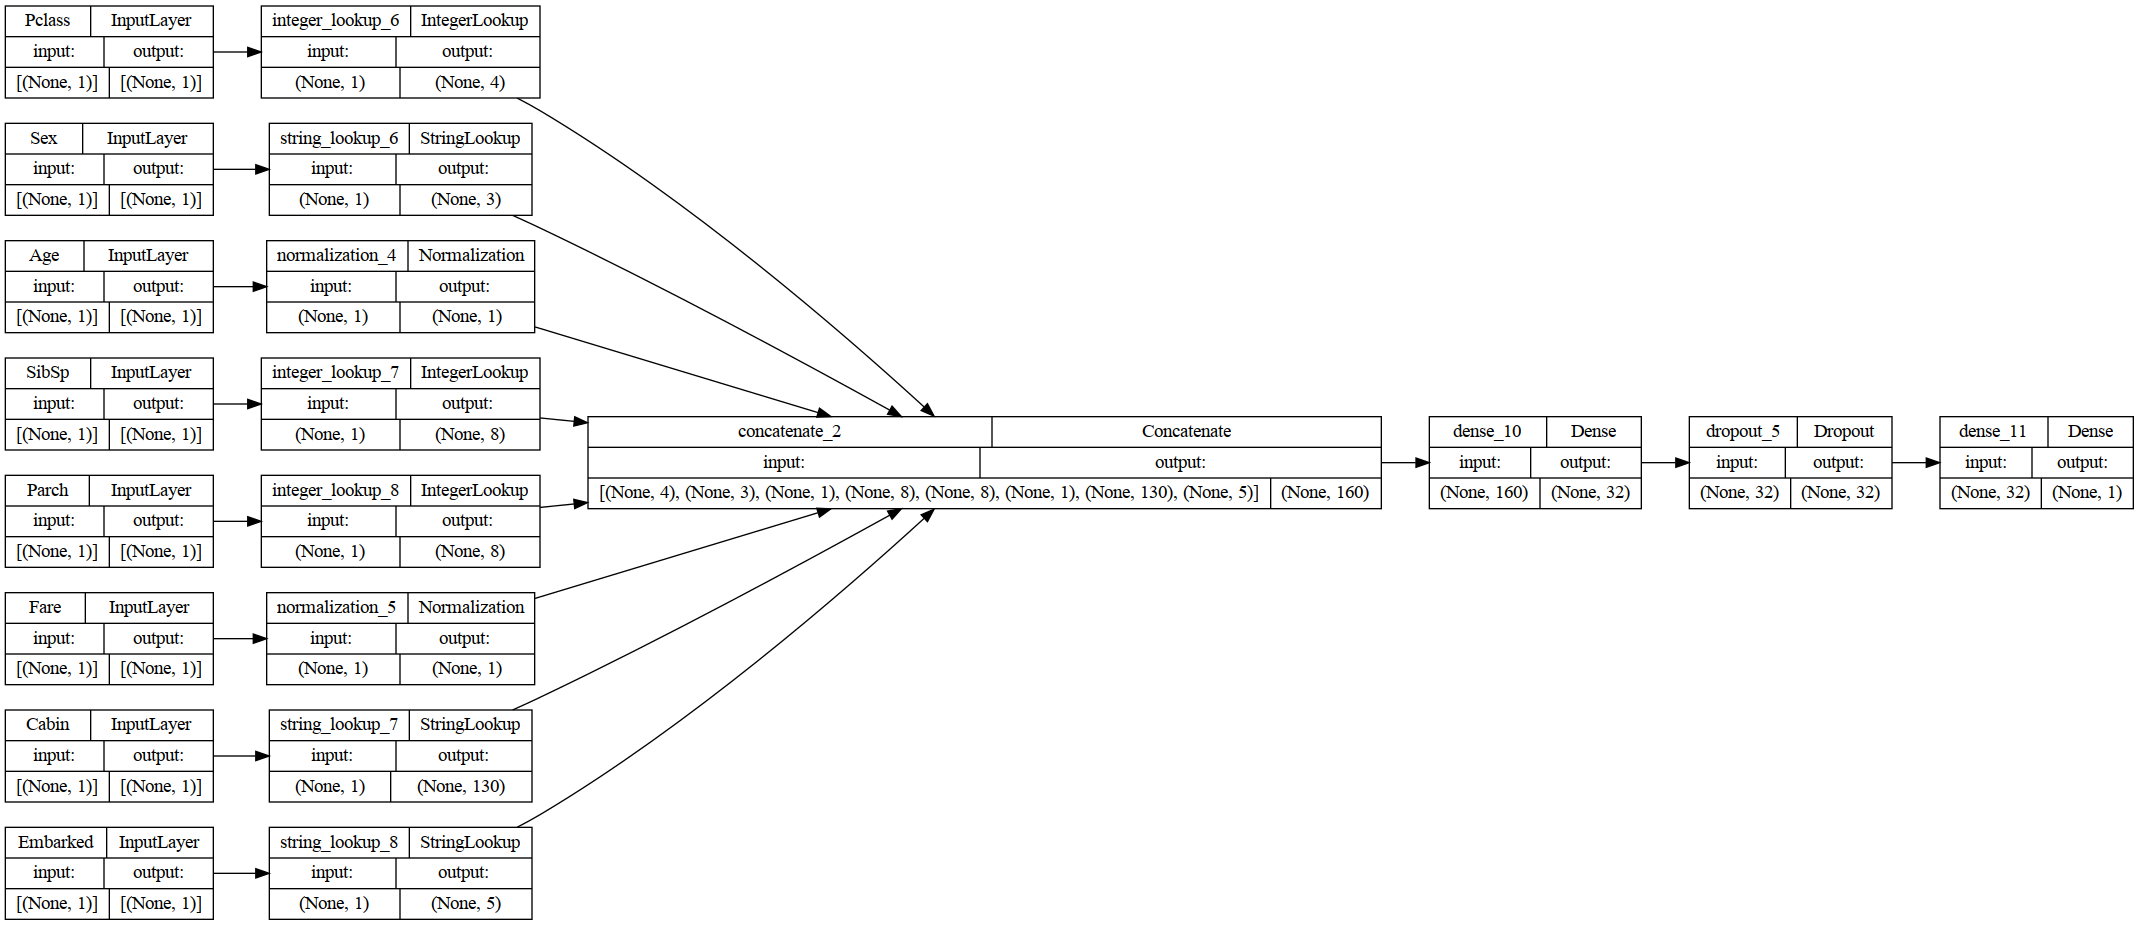

In [93]:
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [94]:
# train model
model.fit(train_ds, epochs=50)

Epoch 1/50


2023-06-30 15:57:35.623339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype string and shape [713]
	 [[{{node Placeholder/_6}}]]
2023-06-30 15:57:35.624157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_8' with dtype int64 and shape [713]
	 [[{{node Placeholder/_8}}]]


23/23 [==============================] - 1s 2ms/step - loss: 0.6988 - accuracy: 0.5330
Epoch 2/50
23/23 [==============================] - 0s 2ms/step - loss: 0.6581 - accuracy: 0.6353
Epoch 3/50
23/23 [==============================] - 0s 2ms/step - loss: 0.6289 - accuracy: 0.6886
Epoch 4/50
23/23 [==============================] - 0s 2ms/step - loss: 0.5952 - accuracy: 0.7251
Epoch 5/50
23/23 [==============================] - 0s 2ms/step - loss: 0.5764 - accuracy: 0.7475
Epoch 6/50
23/23 [==============================] - 0s 1ms/step - loss: 0.5441 - accuracy: 0.7602
Epoch 7/50
23/23 [==============================] - 0s 1ms/step - loss: 0.5296 - accuracy: 0.7518
Epoch 8/50
23/23 [==============================] - 0s 2ms/step - loss: 0.5323 - accuracy: 0.7560
Epoch 9/50
23/23 [==============================] - 0s 2ms/step - loss: 0.5036 - accuracy: 0.7910
Epoch 10/50
23/23 [==============================] - 0s 2ms/step - loss: 0.4941 - accuracy: 0.7826
Epoch 11/50
23/23 [===========